In [1]:
import os
import time
import pickle as pck

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_simpson
from scipy.stats import gaussian_kde

from config.plotting import STD_colors, STD_cmaps

from config.settings import MCMC_DIR, PICS_DIR
from src.source_base import Source


In [2]:
import matplotlib
matplotlib.__version__

'3.10.0'

In [3]:
fn = "20250309_noeps_258n_32w_10000st.pck"
min_var = 0.02

In [4]:
with open(os.path.join(MCMC_DIR, fn), "rb") as pickle_file:
    data = pck.load(pickle_file)

sources: list[Source] = data[0]
results = data[1]

n: int = len(sources)
m: int = 10**3

pdfs = np.ones([n, m])
var = np.ones(n)
means = np.zeros(n)
alphas = np.linspace(0, 1.5, m)
for i, s in enumerate(sources):
    if i % 40 == 0:
        print(f"{i+1}->", end="")
    alpha_i = results[i][1][:, 0]
    kde_i = gaussian_kde(alpha_i)
    means[i] = np.mean(alpha_i)
    var[i] = np.var(alpha_i)
    pdfs[i, :] = kde_i(alphas)
print("finish")

1->41->81->121->161->201->241->finish


In [17]:
plt.style.use('default')
plt.rcParams.update({'font.size': 14})  # Set global font size

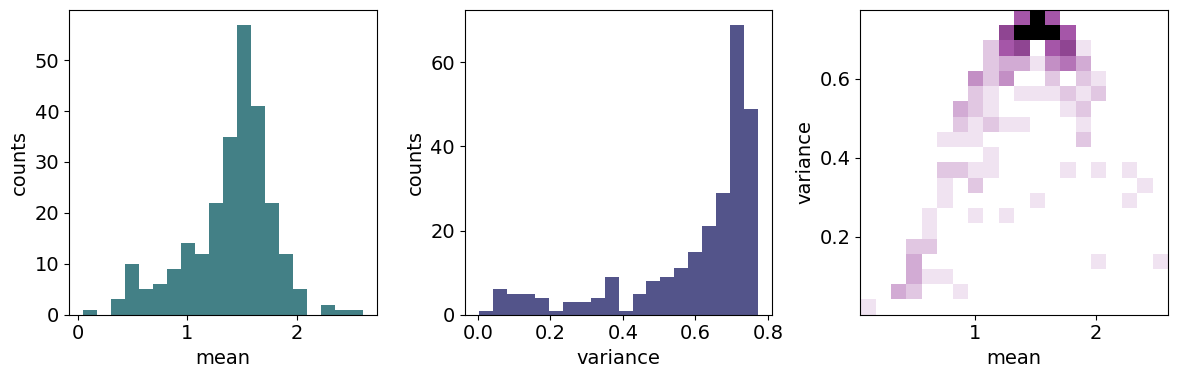

In [18]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(means, bins=20, color=STD_colors[0])
plt.xlabel("mean")
plt.ylabel("counts")

plt.subplot(1, 3, 2)
plt.hist(var, bins=20, color=STD_colors[1])
plt.xlabel("variance")
plt.ylabel("counts")

plt.subplot(1, 3, 3)
plt.hist2d(means, var, 20, cmap=STD_cmaps[2], vmax=10, density=True)
plt.xlabel("mean")
plt.ylabel("variance")

plt.tight_layout()
plt.savefig(os.path.join(PICS_DIR, "means-and-vars.pdf"))
plt.show()

In [13]:
true_vars = var > min_var
true_vars_v = np.sum(true_vars)
true_pdf = pdfs[true_vars]
posteriors = np.prod(true_pdf, axis=0)

mean_i = np.argmax(posteriors)
mean = alphas[mean_i]

print(f"Sources processed: {true_vars_v} sources")
print(f"Posterior: {mean:.3f}")

Sources processed: 257 sources
Posterior: 0.767


In [14]:
norm_j = np.trapezoid(posteriors, alphas)
pdf = posteriors / norm_j
cdf = cumulative_simpson(pdf, x=alphas)

quant_val = 0.9

left_quant_i = np.argmin(abs(cdf - (1 - quant_val)/2))
left_quant = alphas[left_quant_i]
right_quant_i = np.argmin(abs(cdf - (1 + quant_val)/2))
right_quant = alphas[right_quant_i]

print(mean - left_quant, right_quant - mean)

0.11861861861861855 0.13063063063063063


In [15]:
plt.rcParams.update({'font.size': 12})

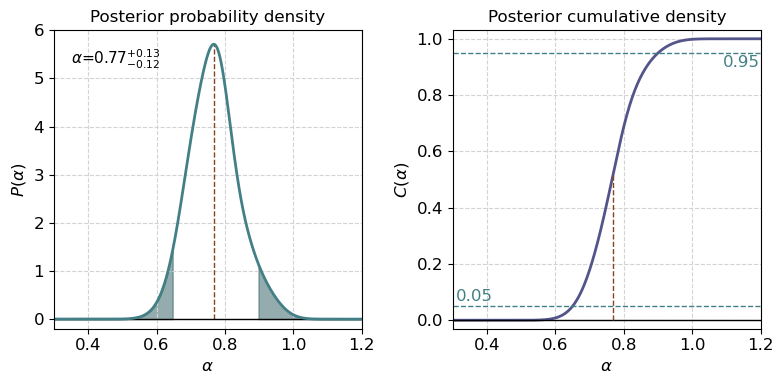

In [16]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Posterior probability density", fontsize=12)
plt.fill_between(alphas[:left_quant_i], np.zeros_like(alphas[:left_quant_i]), pdf[:left_quant_i],
                 color=STD_colors[6], alpha=0.5)
plt.fill_between(alphas[right_quant_i:], np.zeros_like(alphas[right_quant_i::]), pdf[right_quant_i::],
                 color=STD_colors[6], alpha=0.5)
plt.plot((mean, mean), (0, pdf[mean_i]), linestyle='--', color=STD_colors[9], linewidth=1)
plt.text(0.35, 5.3, r"$\alpha$="f"{mean:.2f}"r"${}^{+0.13}_{-0.12}$", fontsize=11)

plt.plot((0, 1.5), (0, 0), linestyle='-', color='black', linewidth=1)

plt.plot(alphas, pdf, color=STD_colors[0], linewidth=2)

plt.grid(linestyle='--', color="lightgrey")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$P(\alpha)$")
plt.xlim(0.3, 1.2)
plt.ylim(-0.2, 6)

plt.subplot(1, 2, 2)
plt.title("Posterior cumulative density", fontsize=12)
plt.plot(alphas[1:], cdf, color=STD_colors[1], linewidth=2)
plt.grid(linestyle='--', color="lightgrey")
plt.plot((0, 1.5), (0, 0), linestyle='-', color='black', linewidth=1)

plt.plot((0, 1.5), (0.05, 0.05), linestyle='--', color=STD_colors[0], linewidth=1)
plt.text(0.31, 0.07, "0.05", color=STD_colors[0])
plt.plot((0, 1.5), (0.95, 0.95), linestyle='--', color=STD_colors[0], linewidth=1)
plt.text(1.09, 0.9, "0.95", color=STD_colors[0])

plt.plot((mean, mean), (0, cdf[mean_i]), linestyle='--', color=STD_colors[9], linewidth=1)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$C(\alpha)$")
plt.xlim(0.3, 1.2)
plt.ylim(-0.03, 1.03)
plt.tight_layout()

plt.savefig(os.path.join(PICS_DIR, "one_parameter_sl_analysis.pdf"))
plt.show()